In [191]:
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv
import calfem.utils as cfu
import calfem.core as cfc
import numpy as np
from plantml import plantml

import matplotlib as mpl

Parameters

In [192]:
E = 5                   #Young's modulus, E [GPa]
v = 0.36                #Poisson's ratio, ν [-]
alpha = 0.00006         #Expansion coefficient, α [1/K]
p = 540                 #Density, ρ [kg/m3]
cp = 3600               #Specific heat, cp [J/kg-K]
k = 80                  #Thermal conductivity, k [W/m-K]
t = 1.6
D = k*np.eye(2)

alpha_c = 120 # W/m2K
alpha_n = 40 # W/m^2K

T_in = 277 # Kelvin
T_out = 285 # Kelvin
T_inf = 293 # Kelvin
T_0 = 293 # Kelvin

In [193]:
g = cfg.Geometry() #Create geometry

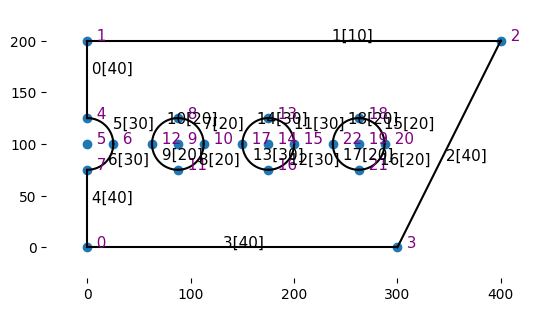

In [194]:
MARKER_T_INF = 10
MARKER_T_IN = 20
MARKER_T_OUT = 30
MARKER_ZERO_CONVECTION = 40


g.point([0.0, 0.0]) # point 0
g.point([0.0, 200.0]) # point 1
g.point([400.0, 200.0]) # point 2
g.point([300.0, 0.0]) # point 3

g.point([0, 125]) # point 4
g.point([0, 100]) # center circle 1; point 5
g.point([25, 100])# point 6
g.point([0, 75]) # point 7

g.point([87.5, 125]) # point 8
g.point([87.5, 100]) # center circle 2; point 9
g.point([112.5, 100]) # point 10
g.point([87.5, 75]) # point 11
g.point([62.5, 100]) # point 12

g.point([175, 125]) # point 13
g.point([175, 100]) # center circle 3; point 14
g.point([200, 100]) #  point 15
g.point([175, 75]) # point 16
g.point([150, 100]) # point 17

g.point([262.5, 125]) # point 18
g.point([262.5, 100]) # center circle 3; point 19
g.point([287.5, 100]) #  point 20
g.point([262.5, 75]) # point 21
g.point([237.5, 100]) # point 22


g.spline([4, 1], marker=MARKER_ZERO_CONVECTION)
g.spline([1, 2], marker=MARKER_T_INF)
g.spline([2, 3], marker=MARKER_ZERO_CONVECTION)
g.spline([3, 0], marker=MARKER_ZERO_CONVECTION)
g.spline([0, 7], marker=MARKER_ZERO_CONVECTION)

#circle 1
g.circle([4, 5, 6], marker=MARKER_T_OUT) 
g.circle([6, 5, 7], marker=MARKER_T_OUT)

#circle 2
g.circle([8, 9, 10], marker=MARKER_T_IN) 
g.circle([10, 9, 11], marker=MARKER_T_IN)
g.circle([11, 9, 12], marker=MARKER_T_IN) 
g.circle([12, 9, 8], marker=MARKER_T_IN)

#circle 3
g.circle([13, 14, 15], marker=MARKER_T_OUT) 
g.circle([15, 14, 16], marker=MARKER_T_OUT)
g.circle([16, 14, 17], marker=MARKER_T_OUT) 
g.circle([17, 14, 13], marker=MARKER_T_OUT)

#circle 4
g.circle([18, 19, 20], marker=MARKER_T_IN) 
g.circle([20, 19, 21], marker=MARKER_T_IN)
g.circle([21, 19, 22], marker=MARKER_T_IN) 
g.circle([22, 19, 18], marker=MARKER_T_IN)


g.surface([0, 1, 2, 3, 4, 6, 5], ([7, 8, 9,10], [11,12,13,14], [15,16,17,18]))
cfv.draw_geometry(g)
cfv.show_and_wait()

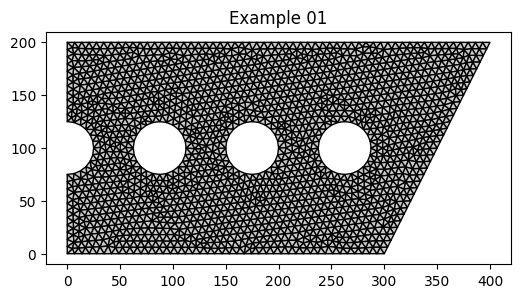

In [195]:
mesh = cfm.GmshMesh(g)

mesh.el_type = 2         # Element type is triangle
mesh.dofs_per_node = 1     # Degrees of freedom per node
mesh.el_size_factor = 7  # Element size Factor

coords, edof, dofs, bdofs, elementmarkers = mesh.create()

cfv.figure()
cfv.drawMesh(
    coords=coords,
    edof=edof,
    dofs_per_node=mesh.dofsPerNode,
    el_type=mesh.elType,
    filled=True,
    title="Example 01"
        )
cfv.show()

In [196]:
def stationary_temp(dofs, coords, edof, bdofs):
    nDofs = np.size(dofs)
    ex, ey = cfc.coordxtr(edof, coords, dofs)
    bc = np.array([],'i')
    bcVal = np.array([],'f')

    K = np.zeros([nDofs, nDofs])
    f = np.zeros([nDofs, 1])
    Kc = np.zeros([nDofs, nDofs])

    for eltopo, elx, ely in zip(edof, ex, ey):
        Ke = cfc.flw2te(elx, ely, [t], D)
        cfc.assem(eltopo, K, Ke)
        
        for i in range(3):
            for j in range(i+1, 3):
                fe = 0
                Kce = np.zeros((2,2))
                if eltopo[i] in bdofs[MARKER_T_INF] and eltopo[j] in bdofs[MARKER_T_INF]:
                    # do convection things
                    dist = np.linalg.norm(coords[eltopo[i]-1]-coords[eltopo[j]-1])/1000
                    fe += T_inf*t*alpha_n*dist  
                    Kce = alpha_n*t*dist*np.array([[2, 1], [1, 2]])/6
                    
                elif eltopo[i] in bdofs[MARKER_T_IN] and eltopo[j] in bdofs[MARKER_T_IN]:
                    # do const flux
                    dist = np.linalg.norm(coords[eltopo[i]-1]-coords[eltopo[j]-1])/1000
                    fe += T_in*t*alpha_c*dist
                    Kce = alpha_c*t*dist*np.array([[2, 1], [1, 2]])/6
                    
                elif eltopo[i] in bdofs[MARKER_T_OUT] and eltopo[j] in bdofs[MARKER_T_OUT]:
                    # do const flux
                    dist = np.linalg.norm(coords[eltopo[i]-1]-coords[eltopo[j]-1])/1000
                    fe += T_out*t*alpha_c*dist
                    Kce = alpha_c*t*dist*np.array([[2, 1], [1, 2]])/6
                    
                cfc.assem(np.array([eltopo[i], eltopo[j]]), K, Kce)
                f[eltopo[i]-1] += fe/2
                f[eltopo[j]-1] += fe/2
    return K, f
""" for element in range(len(edof)):
    ex_n = np.array(ex[element])
    ey_n = np.array(ey[element])

    Cmat = np.vstack((np.ones((3, )), ex_n, ey_n))
    A = np.linalg.det(Cmat)/2
    B = np.matrix([[ey_n[1] - ey_n[2], ey_n[2] - ey_n[0], ey_n[0] - ey_n[1]], 
                [ex_n[2] - ex_n[1], ex_n[0] - ex_n[2], ex_n[1] - ex_n[0]]])
                
    B_e = A*B
    K_e = k * np.matmul(B_e.transpose(1, 0), B_e) * t * A
    cfc.assem(edof, K, K_e) """

' for element in range(len(edof)):\n    ex_n = np.array(ex[element])\n    ey_n = np.array(ey[element])\n\n    Cmat = np.vstack((np.ones((3, )), ex_n, ey_n))\n    A = np.linalg.det(Cmat)/2\n    B = np.matrix([[ey_n[1] - ey_n[2], ey_n[2] - ey_n[0], ey_n[0] - ey_n[1]], \n                [ex_n[2] - ex_n[1], ex_n[0] - ex_n[2], ex_n[1] - ex_n[0]]])\n                \n    B_e = A*B\n    K_e = k * np.matmul(B_e.transpose(1, 0), B_e) * t * A\n    cfc.assem(edof, K, K_e) '

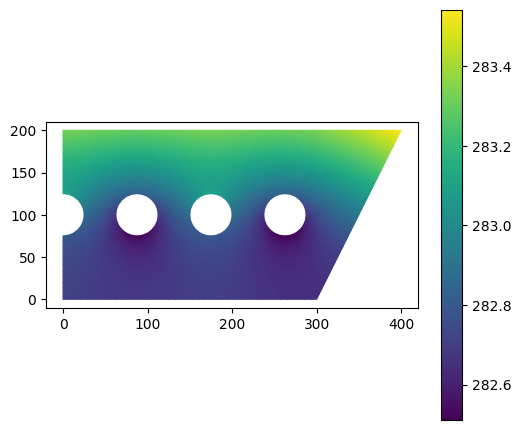

In [197]:
K, f = stationary_temp(dofs, coords, edof, bdofs)
bc = np.array([],'i')
bcVal = np.array([],'f')

#bc, bcVal = cfu.applybc(bdofs, bc, bcVal, ZERO_CONVECTION, 0.0, 0)
#bc, bcVal = cfu.applybc(bdofs, bc, bcVal, CONST_HEAT, 100, 0)

# Solving system
a, r = cfc.solveq(K, f, bc, bcVal)

cfv.figure()
cfv.draw_nodal_values_shaded(a, coords, edof)
cfv.colorbar()
cfv.show()


In [198]:
def transient_step(C, K, f, dt, a_old):
    a, _ = cfc.solveq(C+dt*K, C*a_old + dt*f)
    return a

def transient_temp(tend, number_of_steps, dofs, coords, edof, bdofs, charge_func):
    K, fb = stationary_temp(dofs, coords, edof, bdofs)
    
    nDofs = np.size(dofs)
    ex, ey = cfc.coordxtr(edof, coords, dofs)
    
    C = np.array((nDofs, nDofs))
    for eltopo, elx, ely in zip(edof, ex, ey):
        Ce = plantml(elx, ely, p*t)
        cfc.assem(eltopo, C, Ce)
    
    a = np.zeros((nDofs, number_of_steps))
    
    a_old = np.ones((nDofs, 1))*T_0
    
    dt = tend/number_of_steps
    
    for step in range(number_of_steps):
        a[:][step] = a_old
        fl = np.zeros((nDofs,1))
        for eltopo, elx, ely in zip(edof, ex, ey):
            _, fle = cfc.flw2te(elx, ely, [t], D, charge_func(step*dt))
            cfc.assem(eltopo, fl, fle)
            
        a_old = transient_step(C, K, fb+fl, dt, a_old)
    
    return a

In [199]:
def tempfunc_one(time):
    return 100*np.exp(-144 * ((600-time)/3600)**2 )

def tempfunc_two(time):
    return (time <= 600)*88.42
    
a = transient_temp(1200, 10, dofs, coords, edof, bdofs, tempfunc_two)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed